<a href="https://colab.research.google.com/github/david-siqi-liu/cs684-final-project/blob/master/cs684_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [0]:
!rm -rf sample_data

In [0]:
from urllib.request import urlretrieve
import os
from zipfile import ZipFile

def download(url, file):
    if not os.path.isfile(file):
        urlretrieve(url, file)

#If the downloaded file is a zip file than you can use below function to unzip it.
def uncompress_features_labels(source, file, dest):
    if not os.path.isdir(file):
        with ZipFile(source) as zipf:
            zipf.extractall(dest)

'clipart.zip', 'infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip'

In [59]:
# Source images
for file in ['infograph.zip', 'quickdraw.zip', 'real.zip', 'sketch.zip']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/' + file,
           file)
  print("Downloaded: {0}".format(file))
  uncompress_features_labels(file,
                             'data/' + file.split('.zip')[0],
                             'data/')
  print("Extracted: {0}".format(file))

Downloaded: infograph.zip
Extracted: infograph.zip
Downloaded: quickdraw.zip
Extracted: quickdraw.zip
Downloaded: real.zip
Extracted: real.zip
Downloaded: sketch.zip
Extracted: sketch.zip


In [60]:
# Target images (labelled)
download('http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip', 'clipart.zip')
print("Downloaded: clipart.zip")
uncompress_features_labels('clipart.zip', 'data/clipart', 'data/')
print("Extracted: clipart.zip")

Downloaded: clipart.zip
Extracted: clipart.zip


In [61]:
!mkdir label

mkdir: cannot create directory ‘label’: File exists


In [0]:
# Source labels
for file in ['infograph', 'quickdraw', 'real', 'sketch']:
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_train.txt',
           'label/' + file + '_train.txt')
  download('http://csr.bu.edu/ftp/visda/2019/multi-source/txt/' + file + '_test.txt',
           'label/' + file + '_test.txt')

In [0]:
# Target labels (groundtruth)
download('http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/txt/clipart_test.txt',
           'label/clipart_test.txt')

# Import Packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from PIL import Image, ImageColor
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
USE_GPU = True

# Load Images and Labels

In total there are 345 labels. For this project, we'll downsize this to only 10 labels. For simplicity, we'll use the first 10.

In [66]:
num_labels = 10

np.random.seed(647)

# Randomly select labels
selected_original_labels = np.random.randint(0, 344, num_labels)
selected_original_labels.sort()

print("Selected labels: {0}".format(selected_original_labels))

# Mapping
label_to_original_mapping = {}
for i in range(0, num_labels):
  label_to_original_mapping[i] = selected_original_labels[i]

original_to_label_mapping = {v : k for k, v in label_to_original_mapping.items()}

print("Label to original mapping: {0}".format(label_to_original_mapping))

# Find English term
original_to_english_mapping = {}
for line in open("label/clipart_test.txt"):
  d = line.strip().split(' ')
  l = int(d[1])
  original_to_english_mapping[l] = d[0].split("/")[1]

print("Original to English mapping: {0}".format(original_to_english_mapping))

# Final label mapping
labels = {}
for i in range(0, num_labels):
  labels[i] = original_to_english_mapping[label_to_original_mapping[i]]

print("Labels: {0}".format(labels))

Selected labels: [  7  11  28  43  46  82 116 270 286 328]
Label to original mapping: {0: 7, 1: 11, 2: 28, 3: 43, 4: 46, 5: 82, 6: 116, 7: 270, 8: 286, 9: 328}
Original to English mapping: {0: 'aircraft_carrier', 1: 'airplane', 2: 'alarm_clock', 3: 'ambulance', 4: 'angel', 5: 'animal_migration', 6: 'ant', 7: 'anvil', 8: 'apple', 9: 'arm', 10: 'asparagus', 11: 'axe', 12: 'backpack', 13: 'banana', 14: 'bandage', 15: 'barn', 16: 'baseball', 17: 'baseball_bat', 18: 'basket', 19: 'basketball', 20: 'bat', 21: 'bathtub', 22: 'beach', 23: 'bear', 24: 'beard', 25: 'bed', 26: 'bee', 27: 'belt', 28: 'bench', 29: 'bicycle', 30: 'binoculars', 31: 'bird', 32: 'birthday_cake', 33: 'blackberry', 34: 'blueberry', 35: 'book', 36: 'boomerang', 37: 'bottlecap', 38: 'bowtie', 39: 'bracelet', 40: 'brain', 41: 'bread', 42: 'bridge', 43: 'broccoli', 44: 'broom', 45: 'bucket', 46: 'bulldozer', 47: 'bus', 48: 'bush', 49: 'butterfly', 50: 'cactus', 51: 'cake', 52: 'calculator', 53: 'calendar', 54: 'camel', 55: '

In [0]:
###### LIST LOADER #######

def default_loader(path):
    """Default loader
    """
    return Image.open(path).convert('RGB')

def collect_images(img_dir, labels):
  """Return a list of (image path, label)

  Parameters:
  img_dir (String) : the directory containing the images
  labels (List[String]) : a list of labels (merged multiple sources together)

  Returns:
  List[(String, String)]
  """
  images = []
  indices = {}
  pos = 0
  for line in labels:
    data = line.strip().split(' ')
    path = os.path.join(img_dir, data[0])
    original_label = int(data[1])
    # Among the 10 labels selected
    if original_label in selected_original_labels:
      label = original_to_label_mapping[original_label]
      item = (path, label)
      images.append(item)
      if label not in indices.keys():
        indices[label] = [pos]
      else:
        indices[label].append(pos)
      pos += 1
  return images, indices

class MyDataset(data.Dataset):
    """ Custom class for loading image list
    """
    def __init__(self, img_dir, labels, transform=None, loader=default_loader):
        imgs, indices = collect_images(img_dir, labels)
        self.img_dir = img_dir
        self.imgs = imgs
        self.indices = indices
        self.num_imgs = len(imgs)
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, label = self.imgs[index]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.imgs)

    def get_random_sample_index(self, label, n=1):
      return np.random.choice(self.indices[label], n)[0]

In [0]:
###### IMAGE LOADER #######

def make_data_set(img_dir, label_dir, domain_list, transforms, train_or_test):
  labels = []
  for domain in domain_list:
    # E.g. "label/infograph_test.txt"
    label_file = label_dir + domain + '_' + train_or_test + '.txt'
    for line in open(label_file):
      labels.append(line)
  return MyDataset(img_dir, labels, transforms)

def make_data_loader(dataset, train_or_test):
  if (train_or_test == 'train'):
    return data.DataLoader(dataset, batch_size=4,
                           shuffle=True, num_workers=4)
  else:
    return data.DataLoader(dataset, batch_size=4,
                           shuffle=True, num_workers=4)

In [0]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def tensor_to_PIL(img, mean, std):
  img = img.numpy().transpose((1, 2, 0))
  img = img * std + mean
  img = np.clip(img, 0, 1)
  return img

# Model Evaluation Metrics

In [0]:
def confusion_matrix(preds, targets, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, targets):
        conf_matrix[p, t] += 1

In [0]:
def validate(val_loader, net, vis=True):
  
    conf_matrix = torch.zeros(num_labels, num_labels)
    net.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            
            inputs, target = data

            if USE_GPU:
                inputs = inputs.cuda()
                target = target.cuda()
                net = net.cuda()

            output = net(inputs)

            val_loss += F.nll_loss(output, target, reduction='mean').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            confusion_matrix(output, target, conf_matrix)
    
    val_loss /= len(val_loader.dataset)

    if vis:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            float((num_labels ** 2) * correct / len(val_loader.dataset))))
    
        plt.title('Confusion Matrix')
        plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar()
        plt.xticks(np.arange(num_labels), labels.values(), rotation='vertical')
        plt.yticks(np.arange(num_labels), labels.values())
        plt.show()
        
    net.train()
    return correct / len(val_loader.dataset)

# Baseline Model

We will be using **ResNet50** as our naive/baseline model

In [0]:
home_dir = ''
img_dir = home_dir + 'data/'
label_dir = home_dir + 'label/'
source = ['quickdraw', 'real', 'sketch']
target = ['clipart']

train_transforms = transforms.Compose([transforms.Resize([200, 200]),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize([200, 200]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

target_transforms = transforms.Compose([transforms.Resize([200, 200]),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])

source_train_dataset = make_data_set(img_dir, label_dir, source, train_transforms, 'train')
source_train_dataloader = make_data_loader(source_train_dataset, 'train')
source_test_dataset = make_data_set(img_dir, label_dir, source, test_transforms, 'test')
source_test_dataloader = make_data_loader(source_test_dataset, 'test')

target_dataset = make_data_set(img_dir, label_dir, target, target_transforms, 'test')
target_dataloader = make_data_loader(target_dataset, 'test')

In [73]:
print("Source train dataset size: {0}".format(len(source_train_dataset)))
print("Source test dataset size: {0}".format(len(source_test_dataset)))
print("Target dataset size: {0}".format(len(target_dataset)))

Source train dataset size: 8999
Source test dataset size: 3870
Target dataset size: 443


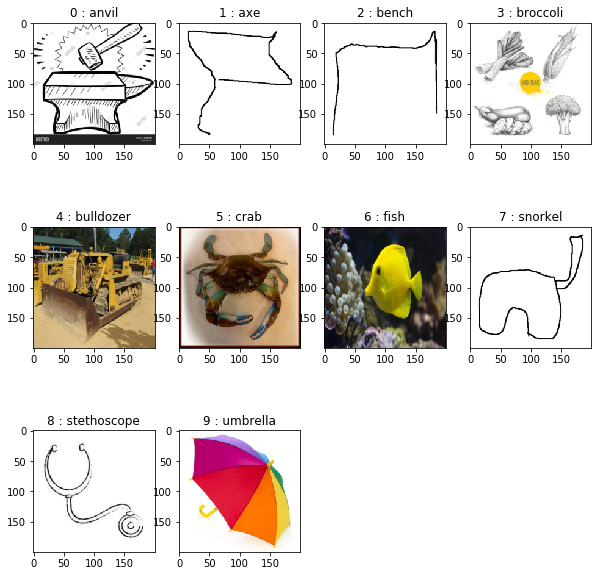

In [74]:
fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_train_dataset.get_random_sample_index(label)
  img, _ = source_train_dataset[index]
  ax1 = fig.add_subplot(3, 4, label+1)
  plt.title("{0} : {1}".format(label, english))
  ax1.imshow(tensor_to_PIL(img, mean, std))

plt.show()

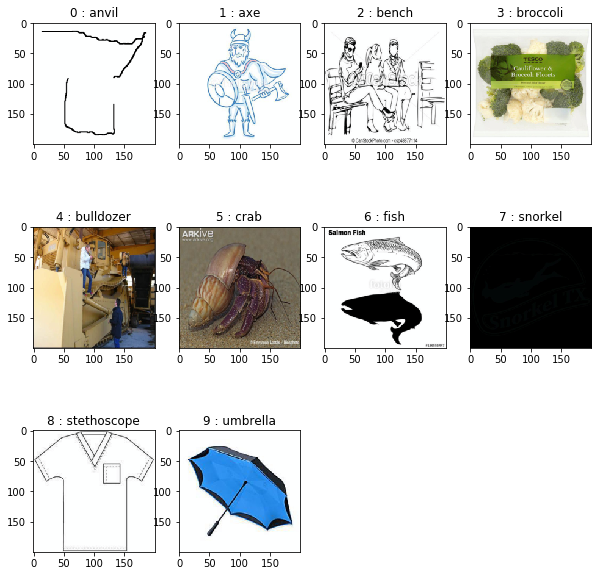

In [75]:
fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_test_dataset.get_random_sample_index(label)
  img, _ = source_test_dataset[index]
  ax1 = fig.add_subplot(3, 4, label+1)
  plt.title("{0} : {1}".format(label, english))
  ax1.imshow(tensor_to_PIL(img, mean, std))

plt.show()

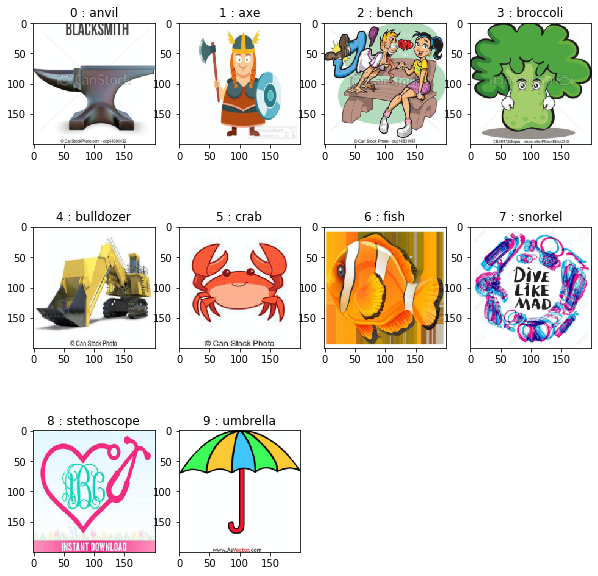

In [76]:
fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_dataset.get_random_sample_index(label)
  img, _ = target_dataset[index]
  ax1 = fig.add_subplot(3, 4, label+1)
  plt.title("{0} : {1}".format(label, english))
  ax1.imshow(tensor_to_PIL(img, mean, std))

plt.show()

In [0]:
import torchvision.models as models

In [0]:
debug = False

class Baseline(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(Baseline, self).__init__()
        # Transfer learning from ResNet50
        resnet = models.resnet50(pretrained = True)
        # Base layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        # ResNet layers
        self.res1 = resnet.layer1
        self.res2 = resnet.layer2
        self.res3 = resnet.layer3
        self.res4 = resnet.layer4
        # Classifier
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(2048, num_classes)
        # Loss Function
        self.criterion = criterion
        
    def forward(self, x, gts=None):
        ### Encoders
        # Base layer
        if debug: print("--START ENCODING")
        if debug: print("Input shape: {0}".format(x.shape))
        out = self.conv1(x)
        if debug: print("After conv1: {0}".format(out.shape))
        out = self.bn1(out)
        if debug: print("After bn1: {0}".format(out.shape))
        out = F.relu(out)
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        if debug: print("After base layer: {0}".format(out.shape))
        # ResNet layers
        out = self.res1(out)
        if debug: print("After res1: {0}".format(out.shape))
        out = self.res2(out)
        if debug: print("After res2: {0}".format(out.shape))
        out = self.res3(out)
        if debug: print("After res3: {0}".format(out.shape))
        out = self.res4(out)
        if debug: print("After res4: {0}".format(out.shape))
        # Classifier
        out = self.avgpool(out)
        if debug: print("After AdaptiveAvgPool: {0}".format(out.shape))
        out = torch.flatten(out, 1)
        if debug: print("After flatten: {0}".format(out.shape))
        out = self.fc(out)
        if debug: print("After fc: {0}".format(out.shape))
        out = F.log_softmax(out, dim=1)

        if self.training:
            # Return the loss if in training mode
            return self.criterion(out, gts)      
        else:
            # Return the actual prediction otherwise
            return out

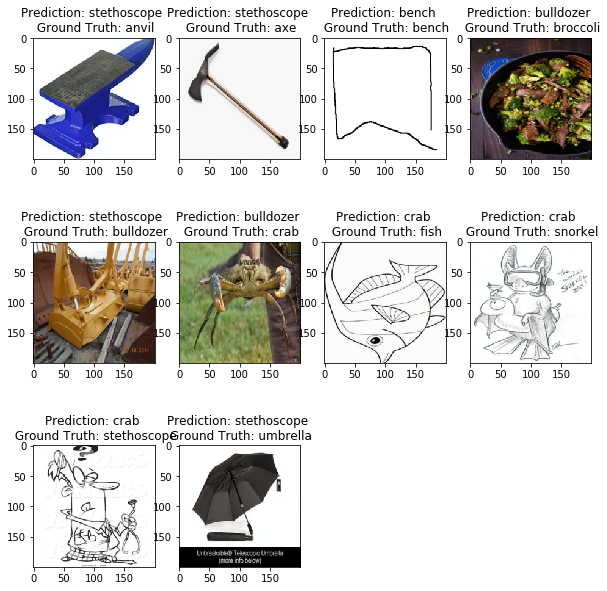

In [79]:
untrained_baseline = Baseline(num_labels).eval()

fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = source_train_dataset.get_random_sample_index(label)
  img, _ = source_train_dataset[index]
  output = untrained_baseline.forward(img[None])
  prediction = int(torch.argmax(output).numpy())
  ax1 = fig.add_subplot(3, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img, mean, std))

plt.show()


Test set: Average loss: 0.5916, Accuracy: 745/8999 (8%)



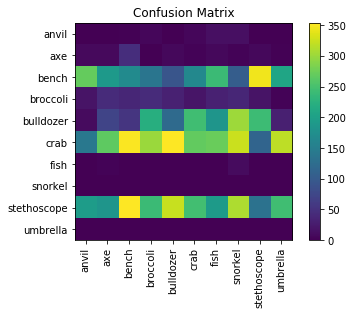

0.08278697633070341

In [80]:
validate(source_train_dataloader, untrained_baseline)

## Train

In [0]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.001,
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

In [0]:
# Training Loop

def train(train_loader, net, optimizer, loss_graph):
    
    for i, data in enumerate(train_loader):
        
        inputs, target = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        main_loss = net(inputs, gts=target)
        loss_graph.append(main_loss.item())
        main_loss.backward()
        optimizer.step()

    return main_loss

2250
Epoch: 0 Loss: 0.7296091914176941
Epoch: 1 Loss: 0.5741329193115234


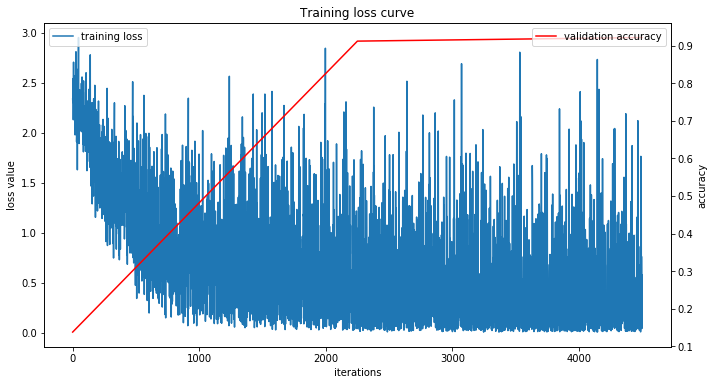

CPU times: user 4min 2s, sys: 36.9 s, total: 4min 39s
Wall time: 5min 14s


In [83]:
%%time

EPOCH = 2

net = Baseline(num_labels, criterion = F.nll_loss)
optimizer = get_optimizer(net)

print(len(source_train_dataloader))

loss_graph = []
val_idx = [0]
val_graph = []
val_graph.append(validate(source_test_dataloader, net, vis=False))
    
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax1 = fig.add_subplot(1,1,1)

ax2 = ax1.twinx()

for e in range(EPOCH):
    loss = train(source_train_dataloader, net, optimizer, loss_graph)
    
    val_idx.append((e + 1) * len(source_train_dataloader))
    val_graph.append(validate(source_test_dataloader, net, vis=False))
    ax1.clear()
    ax1.set_xlabel('iterations')
    ax1.set_ylabel('loss value')
    ax1.set_title('Training loss curve')
    ax1.plot(loss_graph, label='training loss')
    ax1.legend(loc='upper left')
    
    ax2.clear()
    ax2.set_ylabel('accuracy')
    ax2.plot(val_idx, val_graph, label='validation accuracy', color='red')
    ax2.legend(loc='upper right')
    print("Epoch: {} Loss: {}".format(e, loss))
    fig.canvas.draw()
  
plt.show()

# Evaluation of Trained Network


CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA
CUUUUDAAAA


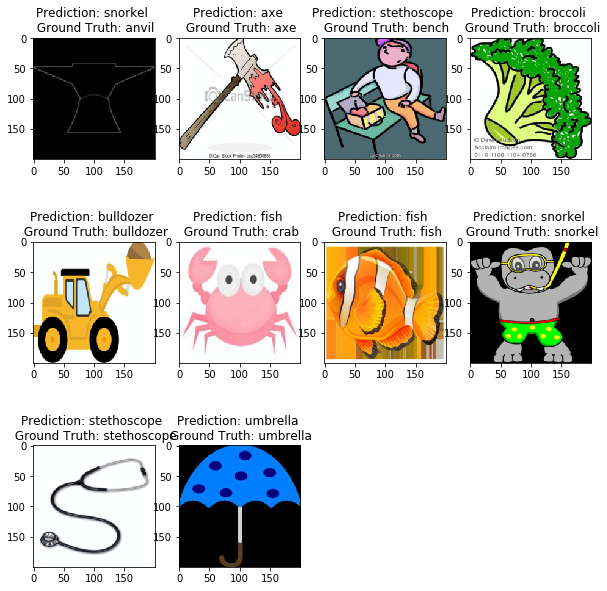

In [93]:
net = net.eval()

fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(hspace=0.5)

for label, english in enumerate(labels.values()):
  index = target_dataset.get_random_sample_index(label)
  img, _ = target_dataset[index]
  if USE_GPU:
      img = img.cuda()
      net = net.cuda()

  output = net.forward(img[None])

  prediction = int(torch.argmax(output).cpu().numpy())

  ax1 = fig.add_subplot(3, 4, label+1)
  plt.title("Prediction: {0} \n Ground Truth: {1}".format(labels[prediction], labels[label]))
  ax1.imshow(tensor_to_PIL(img.cpu(), mean, std))

plt.show()


Test set: Average loss: 0.1369, Accuracy: 372/443 (84%)



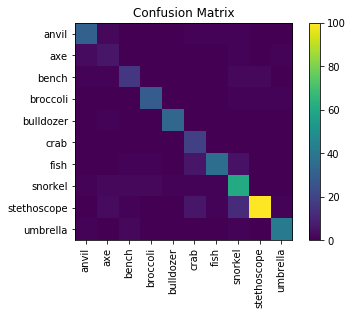

0.8397291196388262

In [94]:
validate(target_dataloader, net)